In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# import atomic.features as fs
# import matplotlib.pyplot as plt
# import pattern.vis as vis
# import sklearn.mixture as mix
# import matplotsoccer as mps
# import atomic.vaep as vaep
# import pattern.action as pat
# import atomic.atomic_spadl as ato
# import pattern.wgmm as wgmm

In [177]:
import numpy as np
from scipy.stats import multivariate_normal
import sklearn.cluster as cluster

class Gauss:
    def fit(self,X,w):
        self.mean = np.average(X,weights=w,axis=0)
        self.covariance = np.cov(X.T,aweights=w)
        return self
        
    def pdf(self,X):
        return multivariate_normal.pdf(X,mean=self.mean,cov=self.covariance)

class MixtureModel:
    
    def __init__(self,k,distribution = Gauss,max_iter=10,tol=1e-05):
        self.k = k
        self.distribution = distribution
        self.max_iter=max_iter
        self.tol=tol
        
    def fit(self,X,verbose=False):
        weights = self.init_weights(X)
        
        # learn models on initial weights
        self.priors = weights.sum(axis=0)/weights.sum()
        self.submodels = list(self.distribution().fit(X,w) for w in weights.T)
        
        iterations = range(self.max_iter) if not verbose else tqdm.tqdm(range(self.max_iter))
        for _i in iterations:
            # Expectation
            for i in range(self.k):
                weights[:,i] =  self.priors[i] * self.submodels[i].pdf(X)
                
            # Maximalization
            self.priors = weights.sum(axis=0)/weights.sum()
            for i in range(self.k):
                self.submodels[i].fit(X,weights[:,i])
        return self
    
    def init_weights(self,X):
        # initialize weights with KMeans
        n_samples,_ = X.shape
        labels = cluster.KMeans(n_clusters=self.k,n_init=1).fit_predict(X)
        weights = np.zeros((n_samples,self.k))
        weights[np.arange(n_samples), labels] = 1
        return weights
    
    def likelihoods(self,X):
        pdfs = np.vstack([m.pdf(X) for m in self.submodels]).T
        return self.prior * pdfs

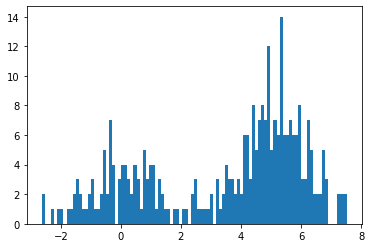

In [163]:
import matplotlib.pyplot as plt

X = np.concatenate([np.random.normal(0,1,10000),np.random.normal(3,1,20000)]).reshape(-1, 1)
plt.hist(x,bins=100)
plt.show()

In [178]:
%%time
model = MixtureModel(3,max_iter=10)
model.fit(X)
model.__dict__

CPU times: user 384 ms, sys: 290 ms, total: 675 ms
Wall time: 103 ms


{'k': 3,
 'distribution': __main__.Gauss,
 'max_iter': 10,
 'tol': 1e-05,
 'priors': array([0.0007976 , 0.65936494, 0.33983746]),
 'submodels': [<__main__.Gauss at 0x7f65d921f780>,
  <__main__.Gauss at 0x7f65d921fa58>]}

In [138]:
%%time
import sklearn.mixture as mix
model = mix.GaussianMixture(2)
model.fit(X)
model.means_,model.covariances_
model.__dict__

CPU times: user 154 ms, sys: 152 ms, total: 306 ms
Wall time: 52.5 ms


{'n_components': 2,
 'tol': 0.001,
 'reg_covar': 1e-06,
 'max_iter': 100,
 'n_init': 1,
 'init_params': 'kmeans',
 'random_state': None,
 'warm_start': False,
 'verbose': 0,
 'verbose_interval': 10,
 'covariance_type': 'full',
 'weights_init': None,
 'means_init': None,
 'precisions_init': None,
 'converged_': True,
 'weights_': array([0.64285662, 0.35714338]),
 'means_': array([[3.04289276],
        [0.09188665]]),
 'covariances_': array([[[0.92014515]],
 
        [[1.0987618 ]]]),
 'precisions_cholesky_': array([[[1.04248984]],
 
        [[0.95399967]]]),
 'precisions_': array([[[1.08678506]],
 
        [[0.91011537]]]),
 'n_iter_': 3,
 'lower_bound_': -1.8980048333845387}